# CHEBI Slimmer

Creates a simplified version of CHEBI ("chemessence") by bundling all members of a **conjugate clique**.
For full motivation, see [this slide deck](https://docs.google.com/presentation/d/1R3NRzH70ERjwebqecgt2OYKC8sIuB1_Xs7ENyWAXgjc/edit#slide=id.p).



## Initial setup

Imports and use OAK to get an adapter to CHEBI sqlite database.

In [1]:
from typing import Optional, List
from collections import defaultdict

import pandas as pd

from oaklib import get_adapter

chebi = get_adapter("sqlite:obo:chebi")
session = chebi.session

In [2]:
from oaklib.datamodels.vocabulary import IS_A, HAS_PART
from oaklib.interfaces import OboGraphInterface

assert isinstance(chebi, OboGraphInterface)


## Set up vocabulary constants

Here we set useful constant variables corresponding to the IDs of relations or terms in CHEBI.

Some of these are used in the transformation, others are used for testing.

In [3]:
# Relations
CBO = "obo:chebi#is_conjugate_base_of"
CAO = "obo:chebi#is_conjugate_acid_of"
TAUTOMER_OF = "obo:chebi#is_tautomer_of"
ENANTIOMER_OF = "obo:chebi#is_enantiomer_of"
HAS_ROLE = "RO:0000087"

In [4]:

CHEMICAL_ENTITY = "CHEBI:24431"

In [5]:
# modify this for testing
# ROOT = AMINO_ACID
ROOT = CHEMICAL_ENTITY

In [6]:
AMINO_ACID = "CHEBI:33709"
AMINO_ACID_ANION = "CHEBI:37022"
ION = "CHEBI:24870" 
ALPHA_AMINO_ACID = "CHEBI:33704"
ALPHA_AMINO_ACID_ANION = "CHEBI:33558"
ALPHA_AMINO_ACID_ZWITTERION = "CHEBI:78608"
CYSTEINE_ZWITTERION = "CHEBI:35237"
L_CYSTEINE_ZWITTERION = "CHEBI:35235"
CYSTEINATE_1_MINUS = "CHEBI:32456"
CYSTEINIUM = "CHEBI:32458"
CORD_E = "CHEBI:213754"
AAAE = "CHEBI:46874"
CITRIC_ACID = "CHEBI:30769"
BETA_AMINO_ACID_ANION = "CHEBI:49095"

AMMONIA="CHEBI:16134"
AMMONIUM="CHEBI:28938"
AZANIDE="CHEBI:29337"
HYRDRIDONITRATE_2M = "CHEBI:29340"
PECTIN = "CHEBI:17309"
WATER = "CHEBI:15377"

CONJ_EXCLUDES = {
    AMMONIA, AMMONIUM, AZANIDE, HYRDRIDONITRATE_2M, PECTIN
}



## Create a map of ID to Label

In [7]:
# Dictionary of CHEBI ID -> primary label
labels = {k: v for k, v in chebi.labels(chebi.entities())}
len(labels)

200959

## Roles

Get a list of all IDs in the role branch.

In [8]:
roles = list(chebi.descendants("CHEBI:50906", [IS_A]))

## Mappings and InChIs

Create mappings

 - `xrefs` of CHEBI ID -> List of Xrefs
 - `inchis` of CHEBI ID -> InChI

In [9]:
# Mappings/xrefs
from semsql.sqla.semsql import Statements, HasDbxrefStatement
q = session.query(HasDbxrefStatement)
xrefs = defaultdict(list)
for row in q:
    if row.subject.startswith("CHEBI:"):
        xrefs[row.subject].append(row.value)

# show number of terms that have at least one mapping
len(xrefs)

161158

In [10]:
# InChIs
q = session.query(Statements).filter(Statements.predicate == "obo:chebi/inchi")
inchis = {row.subject: row.value for row in q}

# show number of terms that have an InChI
len(inchis)

177528

In [11]:
# test
S3H = "CHEBI:113373"
inchis[S3H]

'InChI=1S/C4H8O3.Na/c1-3(5)2-4(6)7;/h3,5H,2H2,1H3,(H,6,7);/q;+1/p-1'

In [12]:
assert all(x.startswith("InChI=1S/") for x in inchis.values())

In [13]:
assert BETA_AMINO_ACID_ANION not in inchis, "grouping classes should not have an inchi"

## Create is-a map

- `is_a_map` : maps CHEBI ID to direct parent IDs

In [14]:
is_as = list(chebi.relationships(predicates=[IS_A]))

In [15]:
is_a_map = defaultdict(list)
for s, _, o in is_as:
    is_a_map[s].append(o)

## Fetch Uniprot Synonyms

One "secret" of CHEBI is that they place biologist-friendly synonyms on the ph 7.3 form. These are tagged "uniprot"

creates a map:

 - `bio_syn_map`: CHEBI ID to biologist-friendly term

In [16]:
from semsql.sqla.semsql import OwlAxiomAnnotation

q = session.query(OwlAxiomAnnotation)
axiom_anns = list(q)

In [17]:
len(axiom_anns)

717222

In [18]:
up_axiom_anns = [row for row in axiom_anns if row.annotation_predicate == "oio:hasDbXref" and row.annotation_value == "UniProt"]

In [19]:
bio_syn_map = {row.subject: row.value for row in axiom_anns if row.annotation_predicate == "oio:hasDbXref" and row.annotation_value == "UniProt"}

# number of terms in CHEBI with uniprot/bio synonym
len(bio_syn_map)

16414

In [20]:
assert bio_syn_map[L_CYSTEINE_ZWITTERION] == "L-cysteine"

In [21]:
# only leaf nodes for ph7.3 terms are included
assert CYSTEINE_ZWITTERION not in bio_syn_map
assert CYSTEINATE_1_MINUS not in bio_syn_map
assert BETA_AMINO_ACID_ANION not in bio_syn_map

## Non-conjugate Relationships

 - `preserved_rels_by_subject`: CHEBI ID to list of relationships

In [22]:
PMAP = {ENANTIOMER_OF: "RO:0018039"}
preserved_rels = list(chebi.relationships(predicates=[HAS_PART, HAS_ROLE, ENANTIOMER_OF]))
preserved_rels_by_subject = defaultdict(list)
for s, p, o in preserved_rels:
    p_mapped = PMAP.get(p, p)
    preserved_rels_by_subject[s].append((p_mapped, o))

In [23]:
len(preserved_rels_by_subject)

28455

In [24]:
assert len(preserved_rels_by_subject) > 20000

## Retrieve all Charge States

Create a mapping

- `charges`: CHEBI ID to integer representing charge state

In [25]:
from semsql.sqla.semsql import Statements, HasDbxrefStatement

session = get_adapter("sqlite:obo:chebi").session
q = session.query(Statements).filter(Statements.predicate == "obo:chebi/charge")
charges = {row.subject: int(row.value) for row in q if row.value is not None}

In [26]:
len(charges)

189127

In [27]:
assert charges[L_CYSTEINE_ZWITTERION] == 0

In [28]:
assert charges[CYSTEINATE_1_MINUS] == -1

In [29]:
assert charges[CITRIC_ACID] == 0

In [30]:
assert AMINO_ACID_ANION not in charges, "X anion terms are agnostic to a SPECIFIC charge"

In [31]:
assert BETA_AMINO_ACID_ANION not in charges

## Validate charge states against InChI

Ensure that the InChI and the charge are valid.

__TODO__: consider using a library such as rdkit for this

In [32]:
# check against inchis
inchi_skip = {}
charges_by_inchi = {}
for id, inchi in inchis.items():
    toks = inchi.split("/")
    # q is charge
    qtoks = [tok for tok in toks if tok.startswith("q")]
    if qtoks:
        qtok = qtoks[0]
        if ";" in qtok:
            qtok = qtok.replace(";", "")
            inchi_skip[id] = qtok
            continue
        if "*" in qtok:
            # print(qtok)
            mparts= qtok[1:].split("*")
            charge = 1
            try:
                for mpart in mparts:
                    charge *= int(mpart)
            except:
                odd.append(id)
                continue
        else:
            try:
                charge = int(qtok[1:])
                charges_by_inchi[id] = charge
            except:
                odd.append(id)
                continue
    # p is protonation
    ptoks = [tok for tok in toks if tok.startswith("p")]
    if ptoks and True:
        ptok = ptoks[0]
        try:
            charge = int(ptok[1:])
            
            if id in charges_by_inchi:
                charges_by_inchi[id] = charge + charges_by_inchi[id]
            else:
                charges_by_inchi[id] = charge
        except:
            pass

# total number of CHEBI terms for which charge can be inferred from InChI
len(charges_by_inchi)

10701

In [33]:
# find all errors/issues

errs = []
for id, charge in charges_by_inchi.items():
    if id not in charges:
        errs.append({"id": id, "inchi_charge": charge, "asserted_charge": None, "type": "MISSING"})
    elif charges[id] != charge:
        errs.append({"id": id, "inchi_charge": charge, "asserted_charge": charges[id], "type": "MISMATCH"})

cedf = pd.DataFrame(errs)
cedf

""


As of the last run, this error report is empty, but in previous iterations many errors found

## Find Conjugate Cliques

Find all cliques connected by conjugate relationships or `TAUTOMER_OF`


In [34]:
conjrels = list(chebi.relationships(predicates=[CBO, CAO, TAUTOMER_OF]))

conjrels = [(s, p, o) for s, p, o in conjrels if not s in CONJ_EXCLUDES and not o in CONJ_EXCLUDES]

assert len(conjrels) > 15000
assert len([r for r in conjrels if r[1] == CBO]) > 8000
assert len([r for r in conjrels if r[1] == TAUTOMER_OF]) > 1500

In [35]:
# number of distinct edges/relationsips
len(conjrels)

18992

Creates a mapping

- `conjrels_by_subject`: CHEBI ID to list of relationsips (pred-obj tuples)

In [36]:
conjrels_by_subject = defaultdict(list)
for s, p, o in conjrels:
    conjrels_by_subject[s].append((p, o))

In [37]:
# number of CHEBI terms that are subject of a conjrule
len(conjrels_by_subject)

17889

In [38]:
conjrels_by_subject["CHEBI:142854"]

[('obo:chebi#is_conjugate_acid_of', 'CHEBI:142858'),
 ('obo:chebi#is_tautomer_of', 'CHEBI:142853')]

In [39]:
assert len(conjrels_by_subject["CHEBI:142854"]) == 2

## Calculate conjugate graph and strongly connected components

We use networkx to find cliques/components from conjugate/tautomer relationships.

We call this `asserted_sccs` as these are asserted in the ontology. This will later be compared with other sources
of cliques (ph7.3 mappings, and lexical analysis)

In [40]:
from typing import Tuple
import networkx as nx
# find strongly connected components using cbos

def calculate_conj_graph(conjrels: List[Tuple[str, str, str]]) -> nx.DiGraph:
    conj_graph = nx.DiGraph()
    for s, _, o in conjrels:
        conj_graph.add_edge(s, o)
        conj_graph.add_edge(o, s)
    return conj_graph

conj_graph = calculate_conj_graph(conjrels)
sccs = list(nx.strongly_connected_components(conj_graph))
asserted_sccs = sccs




In [41]:
# number of distinct components
len(asserted_sccs)

8555

In [42]:
assert len(sccs) > 8000

## Compare conj rels to inchis

In [43]:
def get_string_diff(str1: str, str2: str) -> tuple[str, str]:
    """
    Find the differences between two strings after their common prefix using binary search.
    Returns a tuple of (str1_suffix, str2_suffix) after the common prefix.
    Time complexity: O(log n) where n is the length of the shorter string.
    
    Example:
        get_string_diff('abc123', 'abcXY') -> ('123', 'XY')
        get_string_diff('test-v1', 'test-v2') -> ('1', '2')
        get_string_diff('same', 'same') -> ('', '')
    """
    def find_first_difference(left: int, right: int) -> int:
        """Binary search to find the first position where strings differ."""
        if left >= right:
            return left
            
        mid = (left + right) // 2
        
        # If characters at mid are same, first difference must be after mid
        if mid < len(str1) and mid < len(str2) and str1[mid] == str2[mid]:
            return find_first_difference(mid + 1, right)
        
        # If different or one string ended, first difference must be at or before mid
        return find_first_difference(left, mid)
    
    # Find position of first difference
    pos = find_first_difference(0, min(len(str1), len(str2)))
    
    return str1[pos:], str2[pos:]

assert get_string_diff('abc123', 'abcXY') == ('123', 'XY')

In [44]:
def strip_protonation_state(inchi: str) -> str:
    """
    Strip the protonation state component (p+n or p-n) from an InChI string.
    
    Args:
        inchi (str): Input InChI string
        
    Returns:
        str: InChI string with protonation state removed
        
    Examples:
        >>> strip_protonation_state("InChI=1S/C9H8O4/c1-6(10)13-8-5-7(11)3-2-4-9(8)12/h2-5,11-12H,1H3/p-1")
        'InChI=1S/C9H8O4/c1-6(10)13-8-5-7(11)3-2-4-9(8)12/h2-5,11-12H,1H3'
        
        >>> strip_protonation_state("InChI=1S/C6H5NO2/c8-7(9)6-4-2-1-3-5-6/h1-5H/p+1")
        'InChI=1S/C6H5NO2/c8-7(9)6-4-2-1-3-5-6/h1-5H'
    """
    # Split InChI into layers
    layers = inchi.split('/')
    
    # Remove protonation state layer if present
    filtered_layers = [layer for layer in layers if not layer.startswith('p')]
    prot_layers = [layer for layer in layers if layer.startswith('p')]
    
    # Rejoin layers
    return '/'.join(filtered_layers), prot_layers[0] if prot_layers else None

# Test cases
def test_strip_protonation_state():
    test_cases = [
        (
            "InChI=1S/C9H8O4/c1-6(10)13-8-5-7(11)3-2-4-9(8)12/h2-5,11-12H,1H3/p-1",
            "InChI=1S/C9H8O4/c1-6(10)13-8-5-7(11)3-2-4-9(8)12/h2-5,11-12H,1H3"
        ),
        (
            "InChI=1S/C6H5NO2/c8-7(9)6-4-2-1-3-5-6/h1-5H/p+1",
            "InChI=1S/C6H5NO2/c8-7(9)6-4-2-1-3-5-6/h1-5H"
        ),
        (
            "InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H",  # No protonation state
            "InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H"
        )
    ]
    
    for input_inchi, expected_output in test_cases:
        result, _ = strip_protonation_state(input_inchi)
        assert result == expected_output, f"\nExpected: {expected_output}\nGot: {result}"
        
    print("All test cases passed!")

test_strip_protonation_state()

All test cases passed!


In [45]:
rows = []
no_inchis = set()
bad = []
for s, p, o in conjrels:
    if s not in inchis:
        no_inchis.add(s)
        continue
    if o not in inchis:
        no_inchis.add(o)
        continue
    inchi_s = inchis[s]
    inchi_o = inchis[o]
    diff = get_string_diff(inchi_s, inchi_o)
    deprot_s, ps_s = strip_protonation_state(inchi_s)
    deprot_o, ps_o = strip_protonation_state(inchi_o)
    matches = deprot_s == deprot_o
    rows.append({"p": p, "s": s, "o": o, "diff": diff, "state_s": ps_s, "state_o": ps_o, "matches": matches})
    if not matches:
        bad.append(rows[-1])
diff_df = pd.DataFrame(rows)
diff_df.to_csv("tmp/inchi_conj_diff.csv", index=False)
diff_df  

,p,s,o,diff,state_s,state_o,matches
0,obo:chebi#is_conjugate_acid_of,CHEBI:100147,CHEBI:62070,"(, /p-1)",None,p-1,True
1,obo:chebi#is_conjugate_acid_of,CHEBI:100148,CHEBI:87985,"(, /p-3)",None,p-3,True
2,obo:chebi#is_conjugate_base_of,CHEBI:100241,CHEBI:192486,"(, /p+1)",None,p+1,True
3,obo:chebi#is_tautomer_of,CHEBI:100241,CHEBI:192484,"(, )",None,None,True
4,obo:chebi#is_conjugate_acid_of,CHEBI:10043,CHEBI:78338,"(, /p-1)",None,p-1,True
...,...,...,...,...,...,...,...
16541,obo:chebi#is_conjugate_acid_of,CHEBI:9907,CHEBI:78604,"(t14-,15+,16-,17-,18+,19+,20+,22+,23+,24-/m1/s...",None,p-1,True
16542,obo:chebi#is_conjugate_acid_of,CHEBI:9921,CHEBI:68626,"(b11-8+/t9-,12+,13-/m1/s1, p-1/b11-8+/t9-,12+,...",None,p-1,True
16543,obo:chebi#is_conjugate_base_of,CHEBI:994,CHEBI:77612,"(, )",p-2,p-1,True
16544,obo:chebi#is_conjugate_base_of,CHEBI:994,CHEBI:995,"(p-2/b2-1-,5-4-, b2-1-,5-4-)",p-2,None,True


In [46]:
diff_df[diff_df["matches"] == False]

,p,s,o,diff,state_s,state_o,matches
7,obo:chebi#is_tautomer_of,CHEBI:10057,CHEBI:36441,"(8H,9H2, 3,5-9H,4H2)",None,None,False
8,obo:chebi#is_tautomer_of,CHEBI:10057,CHEBI:36442,"(8H,9H2, 9,12H)",None,None,False
19,obo:chebi#is_tautomer_of,CHEBI:10365,CHEBI:17233,"(/m0/s1, 12-/t16-/m0/s1)",None,None,False
45,obo:chebi#is_conjugate_acid_of,CHEBI:11041,CHEBI:57255,"(-4H,1-2H2,(H,9,10)(H,7,8,11)/t4-/m0/s1, H,1-2...",None,p-1,False
83,obo:chebi#is_tautomer_of,CHEBI:1162,CHEBI:82686,"(,5-3-, )",None,None,False
...,...,...,...,...,...,...,...
16489,obo:chebi#is_conjugate_acid_of,CHEBI:91291,CHEBI:90857,"(,31H,1,10-11H2,2-7H3,(H3,36,37,38,39,40,41,42...",p-2,p-3,False
16497,obo:chebi#is_tautomer_of,CHEBI:915,CHEBI:73089,"(3-4,8-9H,1-2H2,(H,10,11)(H,12,13), 4,8H,1-3H2...",None,None,False
16511,obo:chebi#is_tautomer_of,CHEBI:93166,CHEBI:44401,"(4H,5H2, 5,12H)",None,None,False
16514,obo:chebi#is_conjugate_acid_of,CHEBI:9328,CHEBI:33127,"(10N4O2S/c11-8-2-4-9(5-3-8)17(15,16)14-10-12-6...",None,None,False


In [47]:
diff_summary = diff_df.groupby(["p", "state_s", "state_o", "matches"]).size().reset_index(name='count')
diff_summary = diff_summary.sort_values('count', ascending=False)
diff_summary.to_csv("tmp/inchi_conj_diff_summary.csv", index=False)
diff_summary

,p,state_s,state_o,matches,count
10,obo:chebi#is_conjugate_acid_of,p-1,p-2,True,150
54,obo:chebi#is_conjugate_base_of,p-2,p-1,True,150
21,obo:chebi#is_conjugate_acid_of,p-2,p-3,True,37
59,obo:chebi#is_conjugate_base_of,p-3,p-2,True,37
86,obo:chebi#is_tautomer_of,p-1,p-1,True,32
...,...,...,...,...,...
43,obo:chebi#is_conjugate_base_of,p+4,p+5,True,1
61,obo:chebi#is_conjugate_base_of,p-4,p+1,True,1
44,obo:chebi#is_conjugate_base_of,p-1,p+1,False,1
47,obo:chebi#is_conjugate_base_of,p-1,p-1,True,1


In [48]:
chebi_deprotonated_map = defaultdict(list)
for id, inchi in inchis.items():
    inchi_deprot, state = strip_protonation_state(inchi)
    chebi_deprotonated_map[inchi_deprot].append((id, state))

In [49]:
len(chebi_deprotonated_map)

168894

In [50]:
filtered_chebi_deprotonated_map = {k: v for k, v in chebi_deprotonated_map.items() if len(v) > 1 and any(s for _, s in v)}
len(filtered_chebi_deprotonated_map)

7286

## Lexical analysis

The CHEBI conjugate relationships are incomplete - here we aim to complete them doing a lexical analysis of the labels.

For example,

- foo acid anion
- foo acid(1-)
- foo acid zwitterion

should be in a clique

This does not work in all cases, so we curate/hardcode an exclusion list

In [51]:
# ensure ordering is such that greedy matching works
suffixes = {
    # odd edge cases - e.g. (2R)-glufosinate zwitterion(1-)
    "zwitterion(1-)": -1,
    "zwitterion(2-)": -2,
    "anion(1-)": -1,
    # standard
    "zwitterion": None, 
    "anion": (-99, -1),
    "cation": (1, 99), 
    "ion": None, 
    "ate": None,
    "acid": None,
    
}
for i in range(1, 10):
    for sign in ["+", "-"]:
        suffixes[f"({i}{sign})"] = int(f"{sign}{i}")
suffixes

{'zwitterion(1-)': -1,
 'zwitterion(2-)': -2,
 'anion(1-)': -1,
 'zwitterion': None,
 'anion': (-99, -1),
 'cation': (1, 99),
 'ion': None,
 'ate': None,
 'acid': None,
 '(1+)': 1,
 '(1-)': -1,
 '(2+)': 2,
 '(2-)': -2,
 '(3+)': 3,
 '(3-)': -3,
 '(4+)': 4,
 '(4-)': -4,
 '(5+)': 5,
 '(5-)': -5,
 '(6+)': 6,
 '(6-)': -6,
 '(7+)': 7,
 '(7-)': -7,
 '(8+)': 8,
 '(8-)': -8,
 '(9+)': 9,
 '(9-)': -9}

In [52]:
# https://github.com/ebi-chebi/ChEBI/issues/4528
EXCLUDE_STEMS = ["disulfide", "tartr", "tartar", "oxide", "oxo", "phosph"]

In [53]:
from typing import Dict

# stem to chem is a mapping between a stem (e.g. "L-lysine")
# and a dictionary of suffixes to CHEBI IDs
stem_to_chem: Dict[str, Dict[str, str]] = {}
stem_to_chem = defaultdict(dict)

def _norm(label: str) -> str:
    # CHEBI is inconsistent, e.g. "amino-acid" vs "amino acid"
    label = label.replace("-acid", " acid")
    # label = label.replace(" acid", "")
    return label

def _de_acid(label: str) -> str:
    if label.endswith(" acid"):
        label = label.replace(" acid", "")
    if label.endswith("-acid"):
        label = label.replace(" acid", "")
    if label.endswith("ic"):
        label = label.replace("ic", "")
    if label.endswith("ate"):
        label = label.replace("ate", "")
    return label

for id, label in labels.items():
    if not label:
        # TODO: eliminate non-classes
        continue
    if id in roles:
        continue
    label = _norm(label)
    for suffix in suffixes.keys():
        if label.endswith(suffix):
            stem = label.replace(suffix, "")
            stem = stem.strip()
            stem_to_chem[_de_acid(stem)][suffix] = id
            break
for id, label in labels.items():
    if not label:
        continue
    label = _norm(label)
    if label in stem_to_chem:
        stem_to_chem[_de_acid(label)][""] = id
        
for stem in EXCLUDE_STEMS:
    if stem in stem_to_chem:
        del stem_to_chem[stem]

assert len(stem_to_chem) > 30000

In [54]:
# test this out for some stems

stem_to_chem["amino"]

{'cation': 'CHEBI:33703',
 'acid': 'CHEBI:33709',
 'zwitterion': 'CHEBI:35238',
 'anion': 'CHEBI:37022'}

In [55]:
# should be excluded

stem_to_chem["oxo"]

{}

In [56]:
stem_to_chem["citr"]

{'(4-)': 'CHEBI:132362',
 'anion': 'CHEBI:133748',
 '(3-)': 'CHEBI:16947',
 'acid': 'CHEBI:30769',
 '(1-)': 'CHEBI:35804',
 '(2-)': 'CHEBI:35808'}

In [57]:
assert not stem_to_chem["citrate"]

In [58]:
stem_to_chem["(2R)-glufosin"]

{'ate': 'CHEBI:142853',
 'zwitterion': 'CHEBI:142854',
 'zwitterion(1-)': 'CHEBI:142858'}

In [59]:
# ensure edge case of (2R)-glufosinate zwitterion(1-) is taken care of
assert not stem_to_chem["(2R)-glufosinate zwitterion"]

In [60]:
stem_to_chem["beta-amino"]

{'acid': 'CHEBI:33706', 'anion': 'CHEBI:49095'}

In [61]:
stem_to_chem["beta amino"]

{}

## Analysis: Consistency check between lexically inferred cliques and asserted relationships

Some of this is reported here:

- https://github.com/ebi-chebi/ChEBI/issues/4524


In [62]:
import numpy as np

NO_REL = "NO_REL"
INVERSES = {
    CBO: CAO,
    CAO: CBO,
    TAUTOMER_OF: TAUTOMER_OF,
    NO_REL: NO_REL
}

charge_problems = []
def make_conjrefs(clique_suffix_dict: dict, stem=None) -> List:
    results = []
    for suffix1, chem1 in clique_suffix_dict.items():
        ch1 = suffixes.get(suffix1, None)
        actual_ch1 = charges.get(chem1, None)
        chem1_label = labels.get(chem1, chem1)
        if isinstance(ch1, int):
            if actual_ch1 is None:
                charge_problems.append({"id": chem1, "label": chem1_label, "expected": ch1, "asserted": None, "problem": "MISSING_CHARGE"})
                # raise ValueError(f"Missing charge for {chem1}")
            elif ch1 != actual_ch1:
                charge_problems.append({"id": chem1, "label": chem1_label, "expected": ch1, "asserted": actual_ch1, "problem": "CONFLICTING_CHARGE"})
                # raise ValueError(f"Charge mismatch for {chem1}: {ch1} vs {actual_ch1}")
        elif isinstance(ch1, tuple):
            if actual_ch1 is not None:
                if actual_ch1 < ch1[0] or actual_ch1 > ch1[1]:
                    charge_problems.append({"id": chem1, "label": chem1_label, "expected": ch1, "asserted": actual_ch1, "problem": "OUTSIDE_RANGE"})
                    # raise ValueError(f"Charge mismatch for {chem1}: {ch1} vs {actual_ch1}")
        rels = conjrels_by_subject.get(chem1, [])
        for suffix2, chem2 in clique_suffix_dict.items():
            if suffix1 == suffix2:
                continue
            messages = []
            matched_preds = set()
            actual_p = "NO_REL"
            for p, o in rels:
                if o == chem2:
                    actual_p = p
                    matched_preds.add(p)
            if len(matched_preds) > 1:
                messages.append(f"Multiple matched preds: {matched_preds}")
            
            rev_matched_preds = set()
            rels2 = conjrels_by_subject.get(chem2, [])
            for p, o in rels2:
                if o == chem1:
                    inv_p = INVERSES[p]
                    rev_matched_preds.add(inv_p)
                    if actual_p:
                        if inv_p != actual_p:
                            messages.append(f"Preds mismatch: {actual_p} vs {inv_p}")
                    else:
                        actual_p = inv_p
            if len(rev_matched_preds) > 1:
                messages.append(f"Multiple matched inv preds: {rev_matched_preds}")
            if matched_preds != rev_matched_preds:
                messages.append(f"Preds mismatch: {matched_preds} vs {rev_matched_preds}")
            if messages:
                raise ValueError(f"Error in clique {clique_suffix_dict}: {messages}")
            ch2 = suffixes.get(suffix2, None)
            if ch1 is None or ch2 is None:
                charge_diff = None
                charge_diff_sign = None
            else:
                if isinstance(ch1, int) and isinstance(ch2, int):
                    charge_diff = ch1 - ch2
                    charge_diff_sign = np.sign(charge_diff)
                elif isinstance(ch1, int) and isinstance(ch2, tuple):
                    charge_diff = None
                    if ch1 < ch2[0]:
                        charge_diff_sign = -1
                    elif ch1 > ch2[1]:
                        charge_diff_sign = 1
                    else:
                        charge_diff_sign = 0
                elif isinstance(ch1, tuple) and isinstance(ch2, int):
                    charge_diff = None
                    if ch1[0] < ch2:
                        charge_diff_sign = -1
                    elif ch1[1] > ch2:
                        charge_diff_sign = 1
                    else:
                        charge_diff_sign = 0
                else:
                    charge_diff = None
                    charge_diff_sign = None
            results.append({"suffix1": suffix1 or "NO_SUFFIX",
                            "suffix2": suffix2 or "NO_SUFFIX",
                            "predicate": actual_p,
                            "chem1": chem1,
                            "chem2": chem2,
                            "charge_diff": charge_diff,
                            "charge_diff_sign": charge_diff_sign,
                            "stem": stem,
                            })
    return results
            


In [63]:
# https://github.com/ebi-chebi/ChEBI/issues/4524 -- fixed
len(charge_problems)

0

In [64]:
# test
pd.DataFrame(make_conjrefs(stem_to_chem["amino"]))

,suffix1,suffix2,predicate,chem1,chem2,charge_diff,charge_diff_sign,stem
0,cation,acid,obo:chebi#is_conjugate_acid_of,CHEBI:33703,CHEBI:33709,None,None,None
1,cation,zwitterion,NO_REL,CHEBI:33703,CHEBI:35238,None,None,None
2,cation,anion,NO_REL,CHEBI:33703,CHEBI:37022,None,None,None
3,acid,cation,obo:chebi#is_conjugate_base_of,CHEBI:33709,CHEBI:33703,None,None,None
4,acid,zwitterion,NO_REL,CHEBI:33709,CHEBI:35238,None,None,None
5,acid,anion,obo:chebi#is_conjugate_acid_of,CHEBI:33709,CHEBI:37022,None,None,None
6,zwitterion,cation,NO_REL,CHEBI:35238,CHEBI:33703,None,None,None
7,zwitterion,acid,NO_REL,CHEBI:35238,CHEBI:33709,None,None,None
8,zwitterion,anion,NO_REL,CHEBI:35238,CHEBI:37022,None,None,None
9,anion,cation,NO_REL,CHEBI:37022,CHEBI:33703,None,None,None


In [65]:
# test
pd.DataFrame(make_conjrefs(stem_to_chem["(2R)-glufosin"]))

,suffix1,suffix2,predicate,chem1,chem2,charge_diff,charge_diff_sign,stem
0,ate,zwitterion,obo:chebi#is_tautomer_of,CHEBI:142853,CHEBI:142854,None,None,None
1,ate,zwitterion(1-),NO_REL,CHEBI:142853,CHEBI:142858,None,None,None
2,zwitterion,ate,obo:chebi#is_tautomer_of,CHEBI:142854,CHEBI:142853,None,None,None
3,zwitterion,zwitterion(1-),obo:chebi#is_conjugate_acid_of,CHEBI:142854,CHEBI:142858,None,None,None
4,zwitterion(1-),ate,NO_REL,CHEBI:142858,CHEBI:142853,None,None,None
5,zwitterion(1-),zwitterion,obo:chebi#is_conjugate_base_of,CHEBI:142858,CHEBI:142854,None,None,None


In [66]:
!mkdir -p tmp

In [67]:
charge_problems = []  ## warning - global
lexical_conj_pairs = []
for stem, clique in stem_to_chem.items():
    lexical_conj_pairs += make_conjrefs(clique, stem)

charge_problems_df = pd.DataFrame(charge_problems)
charge_problems_df

#len(lexical_conj_pairs)

,id,label,expected,asserted,problem
0,CHEBI:131605,dicarboxylic acid monoester(1-),-1,NaN,MISSING_CHARGE
1,CHEBI:131861,HODE(1-),-1,NaN,MISSING_CHARGE
2,CHEBI:131862,HPODE(1-),-1,NaN,MISSING_CHARGE
3,CHEBI:131865,EET(1-),-1,NaN,MISSING_CHARGE
4,CHEBI:131873,EpETE(1-),-1,NaN,MISSING_CHARGE
...,...,...,...,...,...
161,CHEBI:88287,Durazol blue 4R(3-),-3,NaN,MISSING_CHARGE
162,CHEBI:88289,ethyl green(1+),1,2.0,CONFLICTING_CHARGE
163,CHEBI:90120,indigo carmine(2-),-2,NaN,MISSING_CHARGE
164,CHEBI:90289,Milling yellow 3G(1-),-1,NaN,MISSING_CHARGE


In [68]:
import pandas as pd
lexical_df = pd.DataFrame(lexical_conj_pairs)
lexical_df

,suffix1,suffix2,predicate,chem1,chem2,charge_diff,charge_diff_sign,stem
0,acid,anion,obo:chebi#is_conjugate_acid_of,CHEBI:100147,CHEBI:62070,NaN,NaN,nalidix
1,anion,acid,obo:chebi#is_conjugate_base_of,CHEBI:62070,CHEBI:100147,NaN,NaN,nalidix
2,acid,NO_SUFFIX,NO_REL,CHEBI:10046,CHEBI:10045,NaN,NaN,Wyerone
3,NO_SUFFIX,acid,NO_REL,CHEBI:10045,CHEBI:10046,NaN,NaN,Wyerone
4,acid,ate,obo:chebi#is_conjugate_acid_of,CHEBI:10072,CHEBI:71201,NaN,NaN,xanthuren
...,...,...,...,...,...,...,...,...
17159,NO_SUFFIX,(1-),obo:chebi#is_conjugate_acid_of,CHEBI:130073,CHEBI:91301,NaN,NaN,"5,20-diHEPE"
17160,(1-),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:9162,CHEBI:79317,NaN,NaN,sinigrin
17161,NO_SUFFIX,(1-),obo:chebi#is_conjugate_acid_of,CHEBI:79317,CHEBI:9162,NaN,NaN,sinigrin
17162,ate,acid,obo:chebi#is_conjugate_base_of,CHEBI:994,CHEBI:995,NaN,NaN,"cis,cis-2-amino-3-(3-oxoprop-1-enyl)but-2-enedio"


In [69]:
# Reported here: https://github.com/ebi-chebi/ChEBI/issues/4525
charge_problems_df.to_csv("tmp/charge_problems.csv", index=False)

## Create lexical cliques

Create cliques/SCCs (`lexical_sccs`) from all lexically derived conjugate base pairs

In [70]:


chem_to_stem: Dict[str, str] = {}
for row in lexical_conj_pairs:
    def _assign(chem: str, stem: str):
        if chem in chem_to_stem:
            if chem_to_stem[chem] != stem:
                raise ValueError(f"Conflicting stems for {chem}: {chem_to_stem[chem]} vs {stem}")
        else:
            chem_to_stem[chem] = stem
    stem = row["stem"]
    _assign(row["chem1"], stem)
    _assign(row["chem2"], stem)

In [71]:
g = calculate_conj_graph([(row["chem1"], "?", row["chem2"]) for row in lexical_conj_pairs])
lexical_sccs = list(nx.strongly_connected_components(g))
len(lexical_sccs)

7518

In [72]:
# group by suffix1, suffix2, predicate, and count the number of rows
summary = lexical_df.groupby(["suffix1", "suffix2", "predicate"]).size().reset_index(name='count')
summary = summary.sort_values('count', ascending=False)
summary.to_csv("tmp/suffix-pairs-summary.csv")
summary

,suffix1,suffix2,predicate,count
353,ate,acid,obo:chebi#is_conjugate_base_of,1522
302,acid,ate,obo:chebi#is_conjugate_acid_of,1522
231,NO_SUFFIX,(1-),obo:chebi#is_conjugate_acid_of,1332
37,(1-),NO_SUFFIX,obo:chebi#is_conjugate_base_of,1332
248,NO_SUFFIX,(4-),obo:chebi#is_conjugate_acid_of,673
...,...,...,...,...
327,anion(1-),anion,NO_REL,1
326,anion(1-),acid,NO_REL,1
201,(6-),(2-),NO_REL,1
202,(6-),(3-),NO_REL,1


In [73]:
df = lexical_df

In [74]:
df[(df["charge_diff_sign"] < 0) & (df["predicate"] == CAO)]

,suffix1,suffix2,predicate,chem1,chem2,charge_diff,charge_diff_sign,stem
15583,(1+),(5+),obo:chebi#is_conjugate_acid_of,CHEBI:83553,CHEBI:82771,-4.0,-1.0,N(4)-bis(aminopropyl)spermidine


In [75]:
df[(df["charge_diff_sign"] > 0) & (df["predicate"] == CBO)]

,suffix1,suffix2,predicate,chem1,chem2,charge_diff,charge_diff_sign,stem
15582,(5+),(1+),obo:chebi#is_conjugate_base_of,CHEBI:82771,CHEBI:83553,4.0,1.0,N(4)-bis(aminopropyl)spermidine


In [76]:
 df.groupby(["predicate"]).size()

predicate
NO_REL                            3252
obo:chebi#is_conjugate_acid_of    6379
obo:chebi#is_conjugate_base_of    6379
obo:chebi#is_tautomer_of          1154
dtype: int64

In [77]:
df.to_csv("tmp/conjrels.csv", index=False)


## Create is-a map

In [78]:
is_as = list(chebi.relationships(predicates=[IS_A]))

In [79]:
is_a_map = defaultdict(list)
for s, _, o in is_as:
    is_a_map[s].append(o)

## Fetch Uniprot Synonyms

One "secret" of CHEBI is that they place biologist-friendly synonyms on the ph 7.3 form. These are tagged "uniprot"

In [80]:
from semsql.sqla.semsql import OwlAxiomAnnotation

q = session.query(OwlAxiomAnnotation)
axiom_anns = list(q)

In [81]:
len(axiom_anns)

717222

In [82]:
up_axiom_anns = [row for row in axiom_anns if row.annotation_predicate == "oio:hasDbXref" and row.annotation_value == "UniProt"]

In [83]:
bio_syn_map = {row.subject: row.value for row in axiom_anns if row.annotation_predicate == "oio:hasDbXref" and row.annotation_value == "UniProt"}
len(bio_syn_map)

16414

In [84]:
len(bio_syn_map)

16414

## Analyze lexically derived relationships

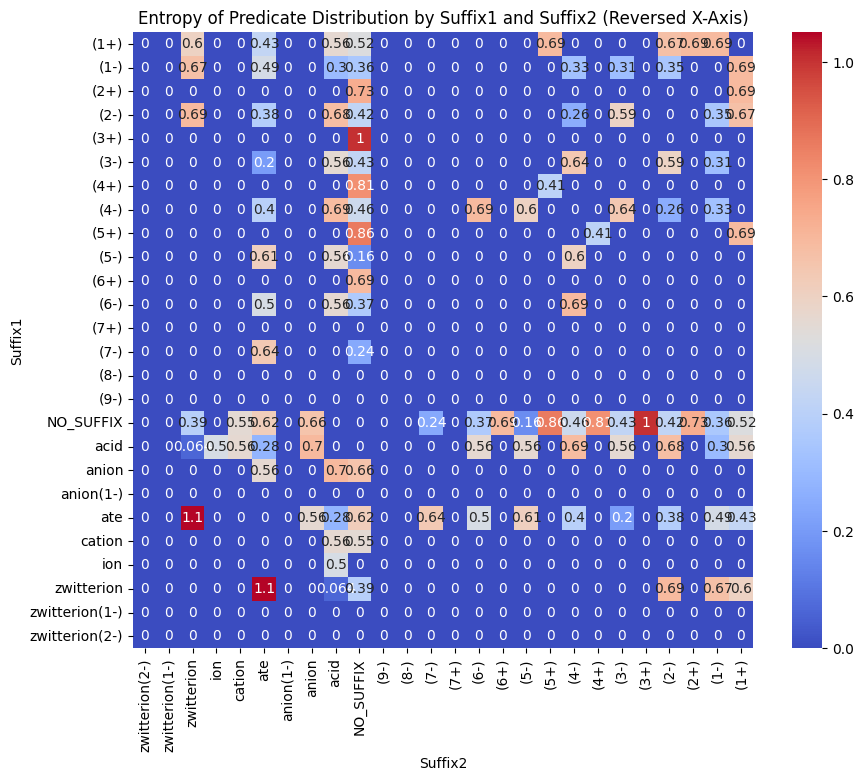

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

data = lexical_df

# Display the first few rows of the data to understand its structure
data.head()

# Create a function to calculate entropy for each group
def calculate_entropy(group):
    counts = group.value_counts(normalize=True)
    return entropy(counts)

# Grouping the data by suffix1 and suffix2, then calculating entropy for the predicates
entropy_data = data.groupby(['suffix1', 'suffix2'])['predicate'].apply(calculate_entropy).unstack(fill_value=0)

# Plotting the entropy heatmap with reversed x-axis
plt.figure(figsize=(10, 8))
sns.heatmap(entropy_data.loc[:, ::-1], annot=True, cmap="coolwarm")
plt.title('Entropy of Predicate Distribution by Suffix1 and Suffix2 (Reversed X-Axis)')
plt.xlabel('Suffix2')
plt.ylabel('Suffix1')
plt.show()


In [86]:
pivot_table = lexical_df.pivot_table(index=['suffix1', 'suffix2'], columns='predicate', aggfunc='size', fill_value=0).reset_index()
pivot_table.to_csv("tmp/pivot_table.csv", index=False)
pivot_table

predicate,suffix1,suffix2,NO_REL,obo:chebi#is_conjugate_acid_of,obo:chebi#is_conjugate_base_of,obo:chebi#is_tautomer_of
0,(1+),(1-),2,2,0,0
1,(1+),(2+),19,0,19,0
2,(1+),(2-),3,2,0,0
3,(1+),(3+),11,0,0,0
4,(1+),(3-),2,0,0,0
...,...,...,...,...,...,...
271,zwitterion(1-),ate,1,0,0,0
272,zwitterion(1-),zwitterion,0,0,3,0
273,zwitterion(2-),(3-),0,1,0,0
274,zwitterion(2-),acid,1,0,0,0


In [87]:
# suspect rows
df = lexical_df
df[(df["suffix1"] == "(1+)") & (df["suffix2"] == "NO_SUFFIX") & (df["predicate"] == CBO)]

,suffix1,suffix2,predicate,chem1,chem2,charge_diff,charge_diff_sign,stem
3028,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:141055,CHEBI:141057,NaN,NaN,validoxylamine B
10934,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:58644,CHEBI:32818,NaN,NaN,p-coumaroylagmatine
12228,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:64003,CHEBI:64004,NaN,NaN,"N-allyl-6-chloro-1-(3-methylphenyl)-2,3,4,5-te..."
12328,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:64364,CHEBI:10650,NaN,NaN,sumatriptan
13404,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:72567,CHEBI:6438,NaN,NaN,levobunolol
14206,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:75297,CHEBI:31057,NaN,NaN,13-deoxydaunorubicin
14380,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:76278,CHEBI:16299,NaN,NaN,dehydrocoformycin
14670,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:76819,CHEBI:15906,NaN,NaN,demethylmacrocin
14696,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:76922,CHEBI:77055,NaN,NaN,argemonine
16424,(1+),NO_SUFFIX,obo:chebi#is_conjugate_base_of,CHEBI:86083,CHEBI:86085,NaN,NaN,(Z)-p-coumaroylagmatine


## RHEA pH Mapping

RHEA provides a table that maps CHEBI IDs to their pH 7.3 stable forms. The mapping may be reflexive
print((e.g.a stable form will map to itself))

The mappings may not be complete - in particular only leaf nodes are mapped.

In [88]:
import pystow
ph_mapping_df = pystow.ensure_csv("rhea", url="https://ftp.expasy.org/databases/rhea/tsv/chebi_pH7_3_mapping.tsv")
for col in ["CHEBI", "CHEBI_PH7_3"]:
    # rewrite to use CURIEs
    ph_mapping_df[col] = "CHEBI:" + ph_mapping_df[col].astype(str)


In [89]:
ph_mapping_df

,CHEBI,CHEBI_PH7_3,ORIGIN
0,CHEBI:3,CHEBI:3,computation
1,CHEBI:7,CHEBI:7,computation
2,CHEBI:8,CHEBI:8,computation
3,CHEBI:19,CHEBI:19,computation
4,CHEBI:20,CHEBI:20,computation
...,...,...,...
119802,CHEBI:691037,CHEBI:691037,computation
119803,CHEBI:691622,CHEBI:691622,computation
119804,CHEBI:741548,CHEBI:132939,computation
119805,CHEBI:744019,CHEBI:744019,computation


In [90]:
# create a dict from the dataframe
ph_mapping = dict(zip(ph_mapping_df['CHEBI'], ph_mapping_df['CHEBI_PH7_3']))

In [91]:
len(ph_mapping)

119807

In [92]:
# we expected leaf and leaf-y nodes to be mapped
assert ph_mapping[CYSTEINATE_1_MINUS] == CYSTEINE_ZWITTERION

In [93]:
assert ph_mapping[CITRIC_ACID] != CITRIC_ACID

In [94]:
# reflexivity
assert ph_mapping[L_CYSTEINE_ZWITTERION] == L_CYSTEINE_ZWITTERION
assert ph_mapping[CYSTEINE_ZWITTERION] == CYSTEINE_ZWITTERION

In [95]:
assert ph_mapping[WATER] == WATER

In [96]:
# groupings are not mapped
assert AMINO_ACID not in ph_mapping

In [97]:
# create a reverse mapping

rev_ph_mapping = defaultdict(list)
for k, v in ph_mapping.items():
    rev_ph_mapping[v].append(k)
    
len(rev_ph_mapping)

111077

In [98]:
rhea_sccs = []
rhea_singletons = []
for _, clique in rev_ph_mapping.items():
    if len(clique) > 1:
        rhea_sccs.append(set(clique))
    else:
        rhea_singletons.append(clique[0])

len(rhea_sccs), len(rhea_singletons)

(8140, 102937)

In [99]:
assert L_CYSTEINE_ZWITTERION in rev_ph_mapping[L_CYSTEINE_ZWITTERION]
assert CYSTEINATE_1_MINUS in rev_ph_mapping[CYSTEINE_ZWITTERION]



## Consistency analysis

venn diagram of overlaps between:

 - lexical_sccs
 - asserted_sccs
 - rhea_sccs

/Users/cjm/repos/chemessence/.venv/lib/python3.9/site-packages/matplotlib_venn/_util.py:62: UserWarning: venn3_unweighted is deprecated. Use venn3 with the appropriate layout_algorithm instead.
  warnings.warn(


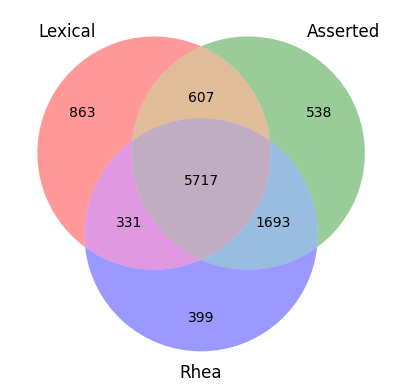

In [100]:


from matplotlib_venn import venn3
from matplotlib_venn import venn3_unweighted

import matplotlib.pyplot as plt

def hashable_scc_for_list(sccs):
    """
    returns a set of hashes of each scc
    """
    return set([tuple(sorted(list(scc))) for scc in sccs])

def my_venn3(sccs_list, *args, **kwargs):
    """
    Draw venn diagram of SCC Lists.

    Note: Each element in each set is a complete SCC, thus if two SCCs
    overlap but are non-identical, they are treated differently.
    """
    scc_sets = [hashable_scc_for_list(sccs) for sccs in sccs_list]
    venn3_unweighted(scc_sets, *args, **kwargs)

my_venn3([lexical_sccs, asserted_sccs, rhea_sccs], ("Lexical", "Asserted", "Rhea"))
plt.show()

## Pick Canonical from Conjugate Cliques

For each clique, pick the canonical term. This will typically be the pH 7.3 term, but this is not always calculated.

Priority order:
    
 1. pH 7.3 mapping
 2. The one with a Uniprot synonym (biologist synonym)
 3. The member that has Charge==0

In [101]:

arbitrary_canonical_map = {}
def pick_canonical(ids: List[str]) -> str:
    """
    Pick the canonical term from a list of ids.
    
    Priority order:
    
    1. pH mapping
    2. Uniprot synonyms
    3. Charge 0
    
    :param ids: SCC
    :return: 
    """
    # ensure deterministic order
    ids = sorted(ids)
    for id in ids:
        if id in ph_mapping:
            return ph_mapping[id]
    for id in ids:
        if id in bio_syn_map:
            return id
    for id in ids:
        if id in charges and charges[id] == 0:
            return id
    # prioritize shorter
    ids = sorted(ids, key=lambda x: len(labels.get(x)))
    for id in ids:
        if id not in charges:
            # last resort
            return id
    if len(ids) == 1:
        return ids[0]
    arbitrary_canonical_map[tuple(ids)] = ids[0]
    return ids[0]
    # raise ValueError(f"Could not find canonical for {ids}")


    

In [102]:
# tests
assert pick_canonical([CITRIC_ACID]) == ph_mapping[CITRIC_ACID]
assert pick_canonical([L_CYSTEINE_ZWITTERION]) == L_CYSTEINE_ZWITTERION
assert pick_canonical([CYSTEINE_ZWITTERION, CYSTEINATE_1_MINUS, CYSTEINIUM]) == CYSTEINE_ZWITTERION
assert pick_canonical([AMINO_ACID, AMINO_ACID_ANION]) == AMINO_ACID
assert pick_canonical([ALPHA_AMINO_ACID, ALPHA_AMINO_ACID_ANION, ALPHA_AMINO_ACID_ZWITTERION]) == ALPHA_AMINO_ACID_ZWITTERION

In [103]:
def my_venn3_canonical(sccs_list, *args, **kwargs):
    """
    Draw venn diagram of SCC Lists.

    Note: Each element in each set is a complete SCC, thus if two SCCs
    overlap but are non-identical, they are treated differently.
    """
    canonicals_lists = []
    for sccs in sccs_list:
        canonicals_lists.append(set([pick_canonical(scc) for scc in sccs]))
    venn3_unweighted(canonicals_lists, *args, **kwargs)

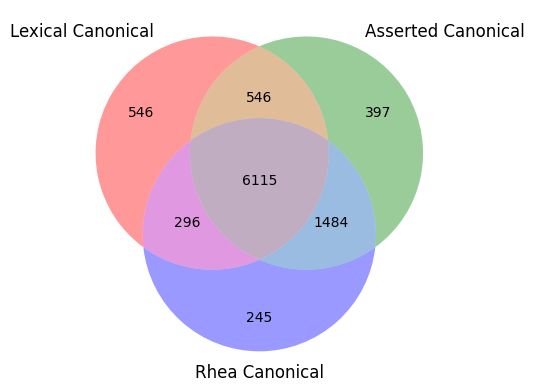

In [104]:
my_venn3_canonical([lexical_sccs, asserted_sccs, rhea_sccs], ("Lexical Canonical", "Asserted Canonical", "Rhea Canonical"))
plt.show()

## Combine all SCCs and group by canonical member



In [105]:
from typing import Set, Tuple


def create_canonical_map(scc_sets: List[Set[str]]) -> Tuple[Dict[str, Set[str]], Dict[str, str]]:
    """
    Create a mapping between canonical and members of the strongly connected components
    
    :param scc_sets: 
    :return: 
    """
    canonical_to_members = {}
    for scc in scc_sets:
        canonical = pick_canonical(scc)
        canonical_to_members[canonical] = scc
    members_to_canonical = {m: c for c, ms in canonical_to_members.items() for m in ms}
    return (canonical_to_members, members_to_canonical)

# Perform on asserted
canonical_to_members, members_to_canonical = create_canonical_map(asserted_sccs)

assert members_to_canonical[CYSTEINE_ZWITTERION] == CYSTEINE_ZWITTERION
assert members_to_canonical[CYSTEINATE_1_MINUS] == CYSTEINE_ZWITTERION

In [106]:
len(canonical_to_members)

8542

In [107]:
assert len(canonical_to_members) > 8000

In [108]:
# assess completeness of the sccs
missing_in_conjugate_sccs = []
for chem in stem_to_chem.keys():
    if chem not in canonical_to_members:
        missing_in_conjugate_sccs.append(chem)
        
len(missing_in_conjugate_sccs)

31432

In [109]:
missing_in_lexical_analysis = []
for chem in canonical_to_members.keys():
    if chem not in chem_to_stem:
        missing_in_lexical_analysis.append(chem)
        
len(missing_in_lexical_analysis)

1928

## Combine all SCCs

In [110]:
# DEPRECATE!
for _, vmap in stem_to_chem.items():
    for v1 in vmap.values():
        for v2 in vmap.values():
            if v1 > v2:
                rel = (v1, "?", v2)
                if rel not in conjrels:
                    conjrels.append(rel)
                # conj_graph.add_edge(v1, v2))
conj_graph = calculate_conj_graph(conjrels)
full_sccs = list(nx.strongly_connected_components(conj_graph))
len(full_sccs)

9324

In [166]:
all_rels = []
for sccs in [lexical_sccs, asserted_sccs, rhea_sccs]:
    for scc in sccs:
        sccl = list(scc)
        v1 = sccl[0]
        for v2 in sccl[1:]:
            rel = (v1, "?", v2)
            all_rels.append(rel)
len(all_rels)


26036

In [167]:
full_graph = calculate_conj_graph(all_rels)


In [168]:
full_sccs = list(nx.strongly_connected_components(full_graph))
len(full_sccs)

9541

This number is the total number of cliques we will use

In [169]:
canonical_to_members, members_to_canonical = create_canonical_map(full_sccs)
assert len(canonical_to_members) > 9000

In [170]:
labels[members_to_canonical[AMINO_ACID]]

'amino acid'

In [171]:
assert members_to_canonical[AMINO_ACID_ANION] == AMINO_ACID

In [172]:
def scc_matches(sccs, x):
    return [scc for scc in sccs if x in scc]

scc_matches(full_sccs, "CHEBI:38709")

[{'CHEBI:38705',
  'CHEBI:38707',
  'CHEBI:38708',
  'CHEBI:38709',
  'CHEBI:38710',
  'CHEBI:38712',
  'CHEBI:38714',
  'CHEBI:38715'}]

In [173]:
members_to_canonical["CHEBI:38709"]

'CHEBI:38712'

In [174]:
len(members_to_canonical)

20229

## Exclusion List

TODO: decide whether to include this

In [175]:
ions = list(chebi.descendants(ION, [IS_A]))
exclusion_list = [ion for ion in ions if ion not in canonical_to_members]

In [176]:
len(exclusion_list)

6637

In [177]:
len([x for x in exclusion_list if x in canonical_to_members])

0

## TODO

In [180]:
exclusion_list = []

In [181]:

for x in [x for x in exclusion_list if x in canonical_to_members]:
    print(x, chebi.label(x), canonical_to_members[x])

In [182]:
# assert AAAC in exclusion_list, f"expected {AAAC} in exclusion_list"
assert CITRIC_ACID not in exclusion_list
assert AMINO_ACID not in exclusion_list

In [183]:
def rewire(id: str) -> Optional[str]:
    """
    Rewire an ID to its canonical form, if it is not in the exclusion list
    :param id: 
    :return: 
    """
    rewired =  members_to_canonical.get(id, id)
    if rewired in exclusion_list:
        return None
    return rewired

In [184]:
rewire(AAAE)

'CHEBI:83410'

In [185]:
assert rewire(AAAE) != AAAE
assert rewire(AAAE) not in exclusion_list

## Generate Ontology

Use the combined SCC list and canonical mappings to create a simplified ontology.

In this ontology:

- all members of a SCC are collapsed to the canonical member
- non-canonical members are merged
- edges pointing to these are re-wired

In [186]:
from typing import Tuple
from pydantic import BaseModel

class Term(BaseModel):
    """
    Class representing a CHEBI ontology term
    """
    stanza_type: str = "Term"
    id: str
    label: str
    synonyms: Optional[List[str]] = None
    xrefs: Optional[List[str]] = []
    alt_ids: Optional[List[str]] = None
    parents: List[str] = []
    relationships: List[Tuple[str, str]] = []
    inchi: Optional[str] = None
    physiologically_stable_form: Optional[str] = None
    comments: List[str] = []
    
    def as_obo(self) -> str:
        name = self.label.replace('{', r'\{')
        lines = [
            f"[{self.stanza_type}]",
            f"id: {self.id}",
            f"name: {name}",
        ]
        lines += [f"synonym: {s}" for s in self.synonyms or []]
        lines += [f"alt_id: {alt_id}" for alt_id in self.alt_ids or []]
        lines += [f"is_a: {is_a}" for is_a in self.parents or []]
        lines += [f"xref: {xref}" for xref in self.xrefs or []]
        lines += [f"relationship: {p} {v}" for p, v in self.relationships or []]
        lines += [f"comment: {'; '.join(self.comments)}"] if self.comments else []
        lines += [f"property_value: chemrof:inchi_string \"{self.inchi}\" xsd:string"] if self.inchi else []
        lines += [f"property_value: chemrof:has_physiologically_stable_form {self.physiologically_stable_form}"] if self.physiologically_stable_form else []
        lines += [""]
        return "\n".join(lines)
        
        
class Ontology(BaseModel):
    terms: List[Term] = []
    
    def as_obo(self) -> str:
        lines = [
            f"ontology: chebi-slim",
             "idspace: chemrof https://w3id.org/chemrof/",
            "",
            ]
        return "\n".join(lines + [t.as_obo() for t in self.terms])

In [187]:
# HACK: ideally we would use uniprot synonym to give terms their biologist-friendly
# protonation-agnostic label. However, these are incomplete, and are never present
# for groupings, including e.g "lysine" (only L-lysine).
# here we lop off the protonation state (as we have made it state-agnostic),
# but this is not a great solution as we still end up with e.g. "lysinium"
BAD_SUFFIXES = [" zwitterion", " ion", "(1+)", "(2+)"] # relabel these

def make_term(id: str) -> Optional[Term]:
    """
    Make a term from an ID
    
    :param id: 
    :return: Term object, or None if term is to be excluded
    """
    #if id in exclusion_list:
    #    return None
    if members_to_canonical.get(id, id) != id:
        # non-canonical members are not included
        return None
    #if id not in initial_terms:
    #    # filter for testing
    #    return None
    label = labels.get(id, id)
    if id in bio_syn_map:
        label = bio_syn_map[id]
    else:
        for suffix in BAD_SUFFIXES:
            if label.endswith(suffix):
                label = label.replace(suffix, "")
    term = Term(id=id, label=label)
    alt_ids = [x for x in canonical_to_members.get(id, []) if x != id]
    if id in ph_mapping:
        term.physiologically_stable_form = ph_mapping[id]
    if alt_ids:
        term.alt_ids = alt_ids
    else:
        alt_ids = []
    equiv_set = [id] + alt_ids
    comments = []
    for alt_id in equiv_set:
        for parent in is_a_map.get(alt_id, []):
            rewired_parent = rewire(parent)
            if rewired_parent and rewired_parent not in term.parents:
                term.parents.append(rewired_parent)
                if rewired_parent != parent or alt_id != id:
                    ch = ""
                    if rewired_parent != parent:
                        ch += "P"
                    if alt_id != id:
                        ch += "C"
                    comments.append(f"Original: {id}->{parent} rewired as {alt_id}->{rewired_parent} ({ch})")
        for (p, o) in preserved_rels_by_subject.get(alt_id, []):
            rewired_o = rewire(o)
            if rewired_o and (p, rewired_o) not in term.relationships:
                term.relationships.append((p, rewired_o))
        # TODO: xrefs
        for xref in xrefs.get(alt_id, []):
            if xref.startswith("PMID:"):
                continue
            term.xrefs.append(xref)
        if alt_id in inchis:
            if not term.inchi:
                term.inchi = inchis[alt_id]
    term.comments = comments
    return term


#assert L_CYSTEINE_ZWITTERION in initial_terms
t = make_term(L_CYSTEINE_ZWITTERION)
assert t.label == "L-cysteine"
print(t.as_obo())

[Term]
id: CHEBI:35235
name: L-cysteine
alt_id: CHEBI:32442
alt_id: CHEBI:32445
alt_id: CHEBI:32443
alt_id: CHEBI:17561
is_a: CHEBI:35237
is_a: CHEBI:59869
is_a: CHEBI:26650
is_a: CHEBI:83813
xref: Gmelin:49993
xref: Reaxys:4128886
xref: Gmelin:325857
xref: Beilstein:4128886
xref: Gmelin:325860
xref: Reaxys:5921923
xref: Gmelin:325856
xref: Beilstein:5921923
xref: YMDB:YMDB00046
xref: Wikipedia:Cysteine
xref: Reaxys:1721408
xref: PDBeChem:CYS
xref: MetaCyc:CYS
xref: KNApSAcK:C00001351
xref: KEGG:D00026
xref: KEGG:C00097
xref: HMDB:HMDB0000574
xref: Gmelin:49991
xref: ECMDB:ECMDB00574
xref: Drug_Central:769
xref: DrugBank:DB00151
xref: CAS:52-90-4
xref: Beilstein:1721408
relationship: RO:0018039 CHEBI:35236
relationship: RO:0000087 CHEBI:78675
relationship: RO:0000087 CHEBI:64577
relationship: RO:0000087 CHEBI:77703
relationship: RO:0000087 CHEBI:77746
comment: Original: CHEBI:35235->CHEBI:59814 rewired as CHEBI:32442->CHEBI:59869 (PC); Original: CHEBI:35235->CHEBI:26650 rewired as CHEB

In [188]:
assert rewire(is_a_map[CORD_E][0]) not in exclusion_list

In [189]:
t = make_term(CORD_E)
print(t.as_obo())


[Term]
id: CHEBI:213754
name: Cordycepamide E
is_a: CHEBI:83410
comment: Original: CHEBI:213754->CHEBI:46874 rewired as CHEBI:213754->CHEBI:83410 (P)
property_value: chemrof:inchi_string "InChI=1S/C15H19NO4/c1-9(2)13-14(18)16(3)12(15(19)20-13)8-10-4-6-11(17)7-5-10/h4-7,9,12-13,17H,8H2,1-3H3/t12-,13+/m0/s1" xsd:string
property_value: chemrof:has_physiologically_stable_form CHEBI:213754



In [190]:
t = make_term("CHEBI:32564")
print(t.as_obo())
assert t.label == "lysinium"

[Term]
id: CHEBI:32564
name: lysinium
alt_id: CHEBI:32563
alt_id: CHEBI:32565
alt_id: CHEBI:25094
is_a: CHEBI:78608
is_a: CHEBI:62031
is_a: CHEBI:35987
xref: Gmelin:815095
xref: Wikipedia:Lysine
xref: Reaxys:1616991
xref: KEGG:C16440
xref: Gmelin:279284
xref: CAS:70-54-2
xref: Beilstein:1616991
relationship: BFO:0000051 CHEBI:50339
relationship: RO:0000087 CHEBI:83056
comment: Original: CHEBI:32564->CHEBI:33719 rewired as CHEBI:32564->CHEBI:78608 (P); Original: CHEBI:32564->CHEBI:26167 rewired as CHEBI:25094->CHEBI:62031 (PC); Original: CHEBI:32564->CHEBI:35987 rewired as CHEBI:25094->CHEBI:35987 (C)
property_value: chemrof:inchi_string "InChI=1S/C6H14N2O2/c7-4-2-1-3-5(8)6(9)10/h5H,1-4,7-8H2,(H,9,10)/p+1" xsd:string
property_value: chemrof:has_physiologically_stable_form CHEBI:32564



In [191]:

# assert CYSTEINE_ZWITTERION in initial_terms
t = make_term(CYSTEINE_ZWITTERION)
assert t.label == "cysteine"
assert "CHEBI:78608" in t.parents
print(t.as_obo())

[Term]
id: CHEBI:35237
name: cysteine
alt_id: CHEBI:15356
alt_id: CHEBI:32456
alt_id: CHEBI:32457
alt_id: CHEBI:32458
is_a: CHEBI:33709
is_a: CHEBI:62031
is_a: CHEBI:26834
is_a: CHEBI:78608
xref: Gmelin:49992
xref: Wikipedia:Cysteine
xref: Reaxys:1721406
xref: KNApSAcK:C00007323
xref: KNApSAcK:C00001351
xref: KEGG:C00736
xref: Gmelin:2933
xref: CAS:3374-22-9
xref: Beilstein:1721406
xref: Reaxys:4128885
xref: Gmelin:363235
xref: Beilstein:4128885
xref: Gmelin:49990
xref: Gmelin:325859
relationship: BFO:0000051 CHEBI:50326
relationship: RO:0000087 CHEBI:78675
comment: Original: CHEBI:35237->CHEBI:35238 rewired as CHEBI:35237->CHEBI:33709 (P); Original: CHEBI:35237->CHEBI:26167 rewired as CHEBI:15356->CHEBI:62031 (PC); Original: CHEBI:35237->CHEBI:26834 rewired as CHEBI:15356->CHEBI:26834 (C); Original: CHEBI:35237->CHEBI:33704 rewired as CHEBI:15356->CHEBI:78608 (PC)
property_value: chemrof:inchi_string "InChI=1S/C3H7NO2S/c4-2(1-7)3(5)6/h2,7H,1,4H2,(H,5,6)" xsd:string
property_value: che

In [195]:
# show parents
# note:
#   - some may be redundant, this will come out in reasoning
#   - the labels are from main CHEBI, and not the newer labels
for is_a in t.parents:
    print(is_a, labels[is_a])

CHEBI:33709 amino acid
CHEBI:62031 polar amino acid zwitterion
CHEBI:26834 sulfur-containing amino acid
CHEBI:78608 alpha-amino acid zwitterion


In [196]:

assert len(t.parents) == 4

In [197]:
print(make_term(ALPHA_AMINO_ACID_ZWITTERION).as_obo())

[Term]
id: CHEBI:78608
name: an alpha-amino acid
alt_id: CHEBI:33558
alt_id: CHEBI:33719
alt_id: CHEBI:33704
is_a: CHEBI:33709
xref: MetaCyc:Alpha-Amino-Acids
xref: KEGG:C05167
xref: KEGG:C00045
comment: Original: CHEBI:78608->CHEBI:35238 rewired as CHEBI:78608->CHEBI:33709 (P)
property_value: chemrof:has_physiologically_stable_form CHEBI:78608



In [198]:
t = make_term("CHEBI:25944")
t.comments
print(t.as_obo())


[Term]
id: CHEBI:25944
name: pesticide
is_a: CHEBI:33232
xref: Wikipedia:Pesticide



In [200]:
t = make_term(members_to_canonical["CHEBI:38709"])
print(t.as_obo())

[Term]
id: CHEBI:38712
name: 2-mercaptosuccinate
alt_id: CHEBI:38709
alt_id: CHEBI:38705
alt_id: CHEBI:38708
alt_id: CHEBI:38714
alt_id: CHEBI:38707
alt_id: CHEBI:38715
alt_id: CHEBI:38710
is_a: CHEBI:38712
is_a: CHEBI:61336
is_a: CHEBI:35695
is_a: CHEBI:38717
is_a: CHEBI:28965
xref: Gmelin:327565
xref: Beilstein:4986676
xref: Gmelin:602204
xref: Gmelin:218084
xref: CAS:70-49-5
xref: Beilstein:1099858
xref: Gmelin:602203
xref: Gmelin:2186863
xref: Beilstein:8141616
xref: Gmelin:327564
xref: Beilstein:4181562
comment: Original: CHEBI:38712->CHEBI:38710 rewired as CHEBI:38712->CHEBI:38712 (P); Original: CHEBI:38712->CHEBI:35695 rewired as CHEBI:38708->CHEBI:35695 (C); Original: CHEBI:38712->CHEBI:38717 rewired as CHEBI:38715->CHEBI:38717 (C); Original: CHEBI:38712->CHEBI:28965 rewired as CHEBI:38710->CHEBI:28965 (C)
property_value: chemrof:inchi_string "InChI=1S/C4H6O4S/c5-3(6)1-2(9)4(7)8/h2,9H,1H2,(H,5,6)(H,7,8)/p-2" xsd:string
property_value: chemrof:has_physiologically_stable_form CHE

In [201]:
GLU_1M = "CHEBI:14321"
assert preserved_rels_by_subject[GLU_1M]
print(make_term(GLU_1M).as_obo())

[Term]
id: CHEBI:14321
name: glutamate
alt_id: CHEBI:29987
alt_id: CHEBI:18237
is_a: CHEBI:78608
is_a: CHEBI:28965
is_a: CHEBI:62031
xref: Gmelin:327908
xref: Reaxys:4134100
xref: Gmelin:327903
xref: Beilstein:4134100
xref: Wikipedia:Glutamic_acid
xref: Reaxys:1723799
xref: KNApSAcK:C00019577
xref: KNApSAcK:C00001358
xref: KEGG:D04341
xref: KEGG:C00302
xref: Gmelin:101971
xref: CAS:617-65-2
xref: Beilstein:1723799
relationship: RO:0000087 CHEBI:78675
relationship: BFO:0000051 CHEBI:50329
comment: Original: CHEBI:14321->CHEBI:33558 rewired as CHEBI:14321->CHEBI:78608 (P); Original: CHEBI:14321->CHEBI:28965 rewired as CHEBI:29987->CHEBI:28965 (C); Original: CHEBI:14321->CHEBI:26167 rewired as CHEBI:18237->CHEBI:62031 (PC)
property_value: chemrof:inchi_string "InChI=1S/C5H9NO4/c6-3(5(9)10)1-2-4(7)8/h3H,1-2,6H2,(H,7,8)(H,9,10)/p-1" xsd:string
property_value: chemrof:has_physiologically_stable_form CHEBI:14321



In [202]:
bio_syn_map[ALPHA_AMINO_ACID_ZWITTERION]

'an alpha-amino acid'

In [203]:
ont = Ontology(terms=[t])
print(ont.as_obo())

ontology: chebi-slim
idspace: chemrof https://w3id.org/chemrof/

[Term]
id: CHEBI:38712
name: 2-mercaptosuccinate
alt_id: CHEBI:38709
alt_id: CHEBI:38705
alt_id: CHEBI:38708
alt_id: CHEBI:38714
alt_id: CHEBI:38707
alt_id: CHEBI:38715
alt_id: CHEBI:38710
is_a: CHEBI:38712
is_a: CHEBI:61336
is_a: CHEBI:35695
is_a: CHEBI:38717
is_a: CHEBI:28965
xref: Gmelin:327565
xref: Beilstein:4986676
xref: Gmelin:602204
xref: Gmelin:218084
xref: CAS:70-49-5
xref: Beilstein:1099858
xref: Gmelin:602203
xref: Gmelin:2186863
xref: Beilstein:8141616
xref: Gmelin:327564
xref: Beilstein:4181562
comment: Original: CHEBI:38712->CHEBI:38710 rewired as CHEBI:38712->CHEBI:38712 (P); Original: CHEBI:38712->CHEBI:35695 rewired as CHEBI:38708->CHEBI:35695 (C); Original: CHEBI:38712->CHEBI:38717 rewired as CHEBI:38715->CHEBI:38717 (C); Original: CHEBI:38712->CHEBI:28965 rewired as CHEBI:38710->CHEBI:28965 (C)
property_value: chemrof:inchi_string "InChI=1S/C4H6O4S/c5-3(6)1-2(9)4(7)8/h2,9H,1H2,(H,5,6)(H,7,8)/p-2" xsd:s

In [204]:
with open("tmp/t.obo", "w") as file:
    file.write(ont.as_obo())

In [205]:
def roots(terms: List[Term]):
    return [t.id for t in terms if not t.parents]

In [206]:

def make_terms_for_ids(ids: List[str]) -> List[Term]:
    """
    Make terms for a list of IDs
    
    :param ids: 
    :return: 
    """
    terms = []
    n = 0
    for id in ids:
        n += 1
        t = make_term(id)
        if t:
            terms.append(t)
        if n % 10000 == 0:
            print(f"Processed {n} IDs, made {len(terms)} terms")
    return terms
        

In [207]:
def write_terms(terms: List[Term], path: str):
    """
    Write terms to a file
    
    :param terms: 
    :param path: 
    :return: 
    """
    ont = Ontology(terms=terms)
    with open(path, "w") as file:
        file.write(ont.as_obo())
        
    

In [208]:
def generate_write_all(ids: List[str], path: str) -> List[Term]:
    """
    Run whole pipeline
    
    :param ids: 
    :param path: 
    :return: 
    """
    terms = make_terms_for_ids(ids)
    write_terms(terms, path)
    return terms

In [209]:
amino_acid_ids = list(chebi.descendants(AMINO_ACID))
assert L_CYSTEINE_ZWITTERION in amino_acid_ids
assert len(amino_acid_ids) > 100

In [210]:
terms = generate_write_all(amino_acid_ids, "tmp/amino_acids.obo")

Processed 10000 IDs, made 7868 terms


In [211]:
term_map = {t.id: t for t in terms}

In [212]:
t = term_map[L_CYSTEINE_ZWITTERION]
print(t.as_obo())

[Term]
id: CHEBI:35235
name: L-cysteine
alt_id: CHEBI:32442
alt_id: CHEBI:32445
alt_id: CHEBI:32443
alt_id: CHEBI:17561
is_a: CHEBI:35237
is_a: CHEBI:59869
is_a: CHEBI:26650
is_a: CHEBI:83813
xref: Gmelin:49993
xref: Reaxys:4128886
xref: Gmelin:325857
xref: Beilstein:4128886
xref: Gmelin:325860
xref: Reaxys:5921923
xref: Gmelin:325856
xref: Beilstein:5921923
xref: YMDB:YMDB00046
xref: Wikipedia:Cysteine
xref: Reaxys:1721408
xref: PDBeChem:CYS
xref: MetaCyc:CYS
xref: KNApSAcK:C00001351
xref: KEGG:D00026
xref: KEGG:C00097
xref: HMDB:HMDB0000574
xref: Gmelin:49991
xref: ECMDB:ECMDB00574
xref: Drug_Central:769
xref: DrugBank:DB00151
xref: CAS:52-90-4
xref: Beilstein:1721408
relationship: RO:0018039 CHEBI:35236
relationship: RO:0000087 CHEBI:78675
relationship: RO:0000087 CHEBI:64577
relationship: RO:0000087 CHEBI:77703
relationship: RO:0000087 CHEBI:77746
comment: Original: CHEBI:35235->CHEBI:59814 rewired as CHEBI:32442->CHEBI:59869 (PC); Original: CHEBI:35235->CHEBI:26650 rewired as CHEB

In [213]:
from oaklib.datamodels.vocabulary import OWL_CLASS

# all_ids = list(chebi.descendants(ROOT))
all_ids = list(chebi.entities(filter_obsoletes=True, owl_type=OWL_CLASS))
print("all ids", len(all_ids))
terms = generate_write_all(all_ids, "tmp/all.obo")


Processed 10000 IDs, made 9967 terms
Processed 20000 IDs, made 19938 terms
Processed 30000 IDs, made 29908 terms
Processed 40000 IDs, made 38752 terms
Processed 50000 IDs, made 48363 terms
Processed 60000 IDs, made 57893 terms
Processed 70000 IDs, made 67396 terms
Processed 80000 IDs, made 76905 terms
Processed 90000 IDs, made 86562 terms
Processed 100000 IDs, made 96416 terms
Processed 110000 IDs, made 106377 terms
Processed 120000 IDs, made 116317 terms
Processed 130000 IDs, made 126277 terms
Processed 140000 IDs, made 135309 terms
Processed 150000 IDs, made 144050 terms
Processed 160000 IDs, made 152949 terms
Processed 170000 IDs, made 161893 terms
Processed 180000 IDs, made 170489 terms
Processed 190000 IDs, made 179530 terms
Processed 200000 IDs, made 189316 terms


In [216]:
len(terms)

190224

In [219]:
tmap = {t.id: t for t in terms}

In [217]:
# many roots expected when we make a subset
len(roots(terms))

3

In [218]:
def terms_as_df(terms: List[Term]) -> pd.DataFrame:
    rows = [t.model_dump() for t in terms]
    return pd.DataFrame(rows)

In [220]:
terms_as_df([tmap[x] for x in roots(terms)])

,stanza_type,id,label,synonyms,xrefs,alt_ids,parents,relationships,inchi,physiologically_stable_form,comments
0,Term,CHEBI:24431,chemical entity,None,[],None,[],[],None,CHEBI:24431,[]
1,Term,CHEBI:36342,subatomic particle,None,[Wikipedia:Subatomic_particle],None,[],[],None,None,[]
2,Term,CHEBI:50906,role,None,[],None,[],[],None,None,[]


In [147]:
#write_terms(terms, f"tmp/{ROOT.replace(':', '_')}.obo")

In [148]:
fertirelin = "CHEBI:177856"

In [149]:
t = make_term(fertirelin)
print(t.as_obo())

[Term]
id: CHEBI:177856
name: fertirelin
is_a: CHEBI:25676
xref: KEGG:D07957
xref: Chemspider:163670
xref: CAS:38234-21-8
property_value: chemrof:inchi_string "InChI=1S/C55H76N16O12/c1-4-59-53(82)44-12-8-20-71(44)54(83)38(11-7-19-60-55(56)57)66-49(78)39(21-30(2)3)65-46(75)27-62-47(76)40(22-31-13-15-34(73)16-14-31)67-52(81)43(28-72)70-50(79)41(23-32-25-61-36-10-6-5-9-35(32)36)68-51(80)42(24-33-26-58-29-63-33)69-48(77)37-17-18-45(74)64-37/h5-6,9-10,13-16,25-26,29-30,37-44,61,72-73H,4,7-8,11-12,17-24,27-28H2,1-3H3,(H,58,63)(H,59,82)(H,62,76)(H,64,74)(H,65,75)(H,66,78)(H,67,81)(H,68,80)(H,69,77)(H,70,79)(H4,56,57,60)/t37-,38-,39-,40-,41-,42-,43-,44-/m0/s1" xsd:string



In [150]:
chebi.label(is_a_map[fertirelin][0])

'oligopeptide'